In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import average_precision_score
import numpy as np
from tqdm import tqdm
import collections
from torch.utils.data.sampler import Sampler
import matplotlib.pyplot as plt

In [2]:
# Modified from https://raw.githubusercontent.com/bnulihaixia/Deep_metric/master/utils/sampler.py
class MPerClassSampler(Sampler):
    """
    At every iteration, this will return m samples per class. For example,
    if dataloader's batchsize is 100, and m = 5, then 20 classes with 5 samples
    each will be returned
    """

    def __init__(self, labels, m, length_before_new_iter=100000):
        if isinstance(labels, torch.Tensor):
            labels = labels.numpy()
        self.m_per_class = int(m) # 4
        self.labels_to_indices = self.get_labels_to_indices(labels)
        self.labels = list(self.labels_to_indices.keys()) # 100
        self.length_of_single_pass = self.m_per_class * len(self.labels) # 400
        self.list_size = length_before_new_iter # 30000

    def get_labels_to_indices(self, labels):
            """
            Creates labels_to_indices, which is a dictionary mapping each label
            to a numpy array of indices that will be used to index into self.dataset
            """
            if torch.is_tensor(labels):
                labels = labels.cpu().numpy()
            labels_to_indices = collections.defaultdict(list)
            for i, label in enumerate(labels):
                labels_to_indices[label].append(i)
            for k, v in labels_to_indices.items():
                labels_to_indices[k] = np.array(v, dtype=int)
            return labels_to_indices

    def __len__(self):
        return self.list_size

    def __iter__(self):
        idx_list = [0] * self.list_size
        i = 0
        num_iters = self.calculate_num_iters()
        for _ in range(num_iters):
            np.random.shuffle(self.labels)
            curr_label_set = self.labels
            for label in curr_label_set:
                t = self.labels_to_indices[label]
                idx_list[i : i + self.m_per_class] = np.random.choice(t, size=self.m_per_class)
                i += self.m_per_class
        return iter(idx_list)

    def calculate_num_iters(self):
        divisor = (
            self.length_of_single_pass
        )
        return self.list_size // divisor

In [3]:
# CIFAR-100 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

# 훈련/평가 데이터셋
train_dataset = torchvision.datasets.CIFAR100(root='CIFAR100_Dataset', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='CIFAR100_Dataset', train=False, download=True, transform=transform)

# 배치 단위로 샘플링 하기 위한 코드
sampler = MPerClassSampler(train_dataset.targets, m=4, length_before_new_iter=len(train_dataset)) # 각 이미지 종류당 4개의 이미지가 배치 단위에 존재하도록 샘플링 됩니다.

# 훈련/평가 데이터로더
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False, sampler=sampler)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

print('데이터셋 및 데이터 로더의 준비가 완료되었습니다!')

100%|██████████| 169M/169M [00:03<00:00, 43.2MB/s]


데이터셋 및 데이터 로더의 준비가 완료되었습니다!


In [4]:
# 특징 추출을 위한 ResNet18 딥러닝 네트워크
class ResNet18FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet18FeatureExtractor, self).__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Fully Connected Layer 제거

    def forward(self, x):
        x = self.feature_extractor(x)
        return x.view(x.size(0), -1)  # Flatten to [batch_size, feature_dim]

# 연산 장치 설정 (GPU가 사용가능 하면 GPU사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 이미지 특징 추출을 위한 ResNet18 딥러닝 네트워크 선언
model = ResNet18FeatureExtractor() # 대조 학습을 적용할 딥러닝 네트워크

# 딥러닝 네트워크를 연산장치로 보냄
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


In [5]:
# E-Book에서 배운 배치 단위 연산이 가능한 대조 손실 함수
# 이중 반복문을 활용하여 동작이 느림
def contrastive_loss_slow(features, labels, margin=0.3):
    # features: 배치 단위의 이미지 특징들 (배치 사이즈 x 특징 차원)
    # labels: 배치 단위의 정답 레이블 (배치 사이즈,)
    # margin: 대조 손실 함수에서 활용되는 마진 값

    batch_size = features.size(0)  # 배치 사이즈
    total_loss = 0  # 전체 손실 값

    for i in range(batch_size):  # 배치 단위의 데이터에서 한 개 선택을 위한 반복문
        for j in range(batch_size):  # 배치 단위의 데이터에서 한 개 선택을 위한 반복문
            if i == j:
                continue  # 자기 자신과 비교하는 경우 제외

            # 두 샘플의 특징 벡터 추출
            feature_i = features[i]
            feature_j = features[j]

            # 유클리드 거리 계산
            distance = torch.dist(feature_i, feature_j, p=2)

            if labels[i] == labels[j]:
                # 같은 종류의 이미지 → 거리를 줄이는 방향으로 손실 계산
                total_loss += distance  # 가까워지도록 유도
            else:
                # 다른 종류의 이미지 → 거리가 margin 이상 되도록 유도
                total_loss += torch.clamp(margin - distance, min=0.0)  # 마진 이하의 거리에선 멀어지도록 유도

    # 평균 손실 계산 (배치 크기로 나누기)
    average_loss = total_loss / batch_size

    return average_loss



# 위의 contrastive_loss_slow 함수를 빠르게 만든 함수
# 연산은 동일하지만 이중 반복문 없이 빠르게 동작합니다.
# 코드가 다소 복잡하기 때문에, 자세히 이해하기 보단, 가져다 사용합시다!
def contrastive_loss_fast(features, labels, margin=0.3):
    # 특징들 표준화
    features = features / (torch.norm(features, p=2, dim=1, keepdim=True) + 1e-12).expand_as(features)

    # 특징 간의 모든 거리 측정하는 거리 배열 계산 (반복문 없이 진행)
    distance_matrix = torch.cdist(features, features, p=2)

    # 특징과 마찬가지로 특징 간의 서로 같은 종류의 이미지인지 다른 종류의 이미지인지 판별하는 배열 계산
    labels_expanded = labels.unsqueeze(0).expand(len(labels), len(labels))
    label_matrix = (labels_expanded == labels_expanded.t()).byte()
    label_matrix.fill_diagonal_(0)  # Exclude self-comparison

    # 위에서 계산해 둔 특징 간의 거리 배열와, 특징 간 이미지 종류를 판별해 둔 배열을 활용해 대조 손실 값 계산
    # same_loss: 같은 종류의 이미지 특징들에 대한 대조 손실 값
    # different_loss: 다른 종류의 이미지 특징들에 대한 대조 손실 값
    same_loss = label_matrix * distance_matrix.pow(2)
    different_loss = (1 - label_matrix) * torch.pow(torch.clamp(margin - distance_matrix, min=0.0), 2)

    # 각 대조 손실 값을 더하고 평균 낸 뒤, 대조 손실 값 반환
    loss = same_loss + different_loss
    return loss.mean()

In [6]:
# 학습 파라미터들
# 여러분들이 수정해도 좋아요!
#epoch = 50
epoch = 5  # 너무 오래 걸려서 5로 수정함.
margin = 0.75


# 옵티마이저 설정
# 2차시에서 활용한 경사 하강법을 활용하여, 가중치를 업데이트 하기 위한 옵티마이저 입니다.
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.0001)

# 학습 반복 (epoch)을 위한 반복 문
for i in range(epoch):
    progress_bar = tqdm(train_dataloader)  # 진행바를 출력하여, 학습 과정을 눈으로 보기 쉽게 만들어 줍니다!

    for data in progress_bar:  # 데이터 로더에서 실제로 배치 단위 데이터를 샘플
        images, labels = data  # 이미지들과 정답 레이블들 분리
        images, labels = images.to(device), labels.to(device)  # GPU 또는 CPU로 이동

        # 이미지들의 특징 추출
        features = model(images)

        # 대조 손실 함수 계산
        # 이중 반복문 기반으로 우리가 공부한 contrastive_loss_slow도 사용해보세요.
        loss = contrastive_loss_fast(features, labels, margin)

        # 역전파: 기울기 계산 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 진행바 출력 표시 업데이트
        progress_bar.set_postfix({"현재 Epoch": i, "현재 대조 손실 값": f"{loss.item():.4f}"})

print(f'총 {epoch} 학습이 완료됐습니다!')

100%|██████████| 391/391 [00:29<00:00, 13.42it/s, 현재 Epoch=4, 현재 대조 손실 값=0.0345]

총 5 학습이 완료됐습니다!


In [7]:
# 데이터 로더로 부터 나온 이미지 특징 추출하는 함수
def extract_features(model, dataloader):  # model: 딥러닝 네트워크, dataloader: 데이터로더
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Extracting Features"):
            inputs = inputs.to(device)
            outputs = model(inputs)  # Feature extraction
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

features, labels = extract_features(model, test_dataloader)

print('\n\n 학습한 딥러닝 네트워크를 활용해 특징 추출이 완료됐습니다!')

Extracting Features: 100%|██████████| 79/79 [00:03<00:00, 22.47it/s]



 학습한 딥러닝 네트워크를 활용해 특징 추출이 완료됐습니다!


In [8]:
# Euclidean Distance로 이미지 검색 구현
def euclidean_distance(query_feature, database_features):
    distances = np.linalg.norm(database_features - query_feature, axis=1)
    return distances

# 검색 결과 얻기
def get_top_k_results(query_feature, database_features, database_labels, k=5):
    distances = euclidean_distance(query_feature, database_features)
    indices = np.argsort(distances)[:k]
    return indices, database_labels[indices]

# 4. mAP 계산
def calculate_map(test_features, test_labels, database_features, database_labels, top_k=5):
    average_precisions = []

    for i in tqdm(range(len(test_features)), desc="Calculating mAP"):
        query_feature = test_features[i]
        query_label = test_labels[i]

        # Database에서 query와 동일한 샘플 제외
        valid_indices = np.setdiff1d(np.arange(len(database_features)), [i])
        valid_database_features = database_features[valid_indices]
        valid_database_labels = database_labels[valid_indices]

        # Database에서 유사한 이미지 찾기
        top_k_indices, top_k_labels = get_top_k_results(query_feature, valid_database_features, valid_database_labels, k=top_k)

        # Relevance binary array (1 for correct, 0 for incorrect)
        relevance = (top_k_labels == query_label).astype(int)

        # Calculate average precision
        if relevance.sum() > 0:
            ap = average_precision_score(relevance, np.arange(len(relevance), 0, -1))  # Rank 기반 AP 계산
            average_precisions.append(ap)

    return np.mean(average_precisions)

# Calculate mAP
map_score = calculate_map(features, labels, features, labels, top_k=5)
print(f"\n\n Mean Average Precision (mAP): {map_score * 100:.2f}%")
print(f"평가 완료!")

Calculating mAP: 100%|██████████| 10000/10000 [02:25<00:00, 68.80it/s]



 Mean Average Precision (mAP): 64.18%
평가 완료!


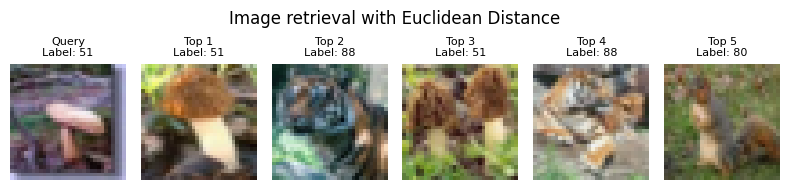

In [9]:
def unnormalize(img, mean, std):
    """
    Normalize를 해제하여 원래 픽셀 값으로 복원.
    Args:
        img: Tensor (C, H, W)
        mean: Normalize에 사용된 평균 값
        std: Normalize에 사용된 표준편차 값
    Returns:
        Unnormalized image (C, H, W)
    """
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # 역으로 std를 곱하고 mean을 더함
    return img

# CIFAR-100의 mean과 std
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

def visualize_query_and_results(query_index, test_features, test_labels, top_k=5):
    query_feature = test_features[query_index]
    query_label = test_labels[query_index]

    # Test set 내부에서 검색 수행 (자기 자신 제외)
    valid_indices = np.setdiff1d(np.arange(len(test_features)), [query_index])
    valid_test_features = test_features[valid_indices]
    valid_test_labels = test_labels[valid_indices]

    top_k_indices, top_k_labels = get_top_k_results(query_feature, valid_test_features, valid_test_labels, k=top_k)

    fig, axes = plt.subplots(1, top_k + 1, figsize=(8, 2))
    fig.suptitle("Image retrieval with Euclidean Distance", fontsize=12)

    query_image, _ = test_dataset[query_index]
    query_image = unnormalize(query_image.clone(), mean, std)
    axes[0].imshow(query_image.permute(1, 2, 0).numpy())
    axes[0].axis('off')
    axes[0].set_title(f"Query\nLabel: {query_label}", fontsize=8)

    for i, idx in enumerate(top_k_indices):
        retrieved_image, _ = test_dataset[valid_indices[idx]]
        retrieved_image = unnormalize(retrieved_image.clone(), mean, std)
        axes[i + 1].imshow(retrieved_image.permute(1, 2, 0).numpy())
        axes[i + 1].axis('off')
        axes[i + 1].set_title(f"Top {i + 1}\nLabel: {top_k_labels[i]}", fontsize=8)

    plt.tight_layout()
    plt.show()

# 예시 실행
visualize_query_and_results(query_index=3, test_features=features, test_labels=labels, top_k=5)

**- 대조 학습의 실제 구현 과정:** 지난 5차시에서 이론으로만 배웠던 대조 학습을 실제 딥러닝 네트워크(ResNet-18 등)에 적용하는 전체적인 흐름을 익혔습니다. 이미지를 모델에 넣어 특징을 추출하고, 이 특징들 사이의 거리를 기반으로 손실을 계산한 뒤, 역전파를 통해 모델을 학습시키는 과정을 코드로 이해할 수 있었습니다.
**- 데이터 샘플링의 중요성:** 단순히 데이터를 무작위로 뽑는 것이 아니라, 대조 학습을 위해서는 배치 구성 방식이 매우 중요하다는 것을 배웠습니다. 무작위로 샘플링할 경우 배치 내에 '같은 종류의 이미지'가 없을 수 있어 학습이 불가능해진다는 문제점을 알게 되었고, 이를 해결하기 위해 각 종류별로 균형 있게 이미지를 뽑아 배치를 구성해야 한다는 점을 이해했습니다.
**- 손실 함수의 코드화:** "같은 종류는 가깝게, 다른 종류는 멀리"라는 대조 손실 함수의 아이디어를 파이썬 코드로 구현하는 구체적인 로직(조건문을 통한 라벨 비교, 유클리드 거리 계산, 마진 적용 등)을 상세히 배울 수 있었습니다